## Imports

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import random
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
# from matplotlib import animation
# from JSAnimation.IPython_display import display_animation
# import gym
import scipy.stats as stats
from scipy.stats import norm
from collections import namedtuple
import statistics
import time
import os
from collections import deque
%matplotlib inline

import pickle

import import_ipynb
import Generate_Data
import Environment

/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'LogReturn',
       'RSI2', 'MA10', 'MA30', 'MA200', 'EMA10', 'EMA30', 'EMA200', 'ROC10',
       'ROC30', 'MOM10', 'MOM30', '%K10', '%D10', '%K30', '%D30', 'VIX',
       'RiskFreeRate', 'Volume', 'delta', 'gamma', 'theta', 'vega', 'rho'],
      dtype='object')
(3242, 30)
(433, 30)
(3242, 8)
(433, 8)
(3242, 10)
(433, 10)


<string>:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
<string>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


## Defining Model Classes
- Environment: Simulates the trading environment, handling state transitions, reward calculations, and interactions based on stock and option data.

- ReplayMemory: Manages a replay memory buffer to store agent experiences and sample them for training.

- BrainDelta: Implements decision-making for delta hedging, using a simple rule-based or discrete action approach.

- AgentActionValueBase: Interfaces with BrainDelta to perform actions, store experiences in memory, and update the agent based on replay.

In [2]:
class ReplayMemory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)
    
    def push(self, state, action, state_next, reward):
        self.memory.append((state, action, state_next, reward))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [3]:
class BrainDelta:
    
    def __init__(self, num_states, num_actions, is_rounded=True, capacity=10000):
        """
        BrainDelta is responsible for the decision-making process of the agent.
        
        Parameters:
        - num_states: The dimensionality of the state space.
        - num_actions: The number of possible actions the agent can take.
        - is_rounded: Whether the actions should be rounded (discrete actions).
        - capacity: The capacity of the replay memory.
        """
        self.num_states = num_states
        self.num_actions = num_actions
        self.is_rounded = is_rounded
        self.memory = ReplayMemory(capacity)  # Experience replay memory

    def replay(self, batch_size=32):
        return

    def decide_action(self, state, episode=None, epsilon=0.1):
        if self.is_rounded:
            return np.round(state[2])
        else:
            return state[2]

In [4]:
class AgentActionValueBase:
    
    def __init__(self, brain):
        self.brain = brain
    
    def update_agent(self):
        self.brain.replay()
    
    def get_action(self, state, step=None, episode=None):
        action = self.brain.decide_action(state, episode)
        action = np.clip(action, -10, 10)
        return action
    
    def memorize(self, state, action, state_next, reward):
        self.brain.memory.push(state, action, state_next, reward)

## Model Training

In [5]:
def train_agent(env, agent, num_episodes=1000, num_steps=30, gamma=0.99):
    """
    Trains the agent in the given environment.

    Parameters:
    - env: The trading environment (DeltaHedgingEnv).
    - agent: The RL agent (AgentActionValueBase).
    - num_episodes: The number of training episodes.
    - num_steps: The number of steps per episode.
    - gamma: Discount factor for future rewards.

    Returns:
    - pl_history: A list containing the P&L history for each episode.
    - reward_history: A list containing the cumulative reward history for each episode.
    """
    
    pl_history = []  # Profit and loss history for each episode
    reward_history = []  # Total reward history for each episode
    std_pl_history = []  # Standard deviation of P&L for each episode ; added this 

    last_30_pl = []
    
    for episode in range(num_episodes):
        state = env.reset()  # Reset the environment and get the initial state
        total_reward = 0  # Track total reward for the episode
        pl_episode = []  # Track portfolio value (P&L) for the episode

        for step in range(num_steps):
            # Agent takes an action based on the current state
            action = agent.get_action(state, step=step, episode=episode)
            
            # Environment returns the next state, reward, and whether the episode is done
            next_state, reward, done, pv = env.step(action)
            
            # Accumulate total reward, discounted by gamma (for future rewards)
            total_reward += reward * np.power(gamma, episode)
            
            # Store the portfolio value (P&L) for the step
            pl_episode.append(pv)
            
            # Memorize the experience
            agent.memorize(state, action, next_state, reward)
            
            # Update the agent
            agent.update_agent()

            # Move to the next state
            state = next_state
            
            # If the episode is done, break out of the loop
            if done:
                break
        
        # At the end of the episode, calculate the total P&L and reward
        pl_total = sum(pl_episode)
        pl_history.append(pl_total)
        reward_history.append(total_reward)
        #std_pl_history.append(np.std(pl_episode))

        last_30_pl.append(pl_total)
        if len(last_30_pl) > 30:
            last_30_pl.pop(0)

        if episode >= 30:
            std = np.std(last_30_pl)
            std_pl_history.append(std)
        else:
            std_pl_history.append(np.nan)

        # if episode % 30 == 0 and episode != 0:
        #     std_pl_history.append(np.std(pl_episode[-30:]))  # Compute std dev of P&L for the episode # added this
        
        # Print progress every 100 episodes
        if episode % 100 == 0:
            print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}, P&L: {pl_total}, Std Dev P&L: {std_pl_history[-1]}") # added std dev part
    
    return pl_history, reward_history, std_pl_history # added std dev

Episode 0/1000, Total Reward: 229.16002585467902, P&L: 1074.0188598632812, Std Dev P&L: nan
Episode 100/1000, Total Reward: -14.092859247457676, P&L: -506.0047149658203, Std Dev P&L: 1049.870741440828
Episode 200/1000, Total Reward: 3.7393652050861537, P&L: -103.47843170166016, Std Dev P&L: 650.1791506071654
Episode 300/1000, Total Reward: 1.201435626027108, P&L: -55.04179000854492, Std Dev P&L: 493.28294093577136
Episode 400/1000, Total Reward: -1.4508200548527372, P&L: -24.971580505371094, Std Dev P&L: 662.2263158808348
Episode 500/1000, Total Reward: 0.047303100106352, P&L: 28.260135650634766, Std Dev P&L: 430.14142052728033
Episode 600/1000, Total Reward: 0.04851265125349896, P&L: 29.107189178466797, Std Dev P&L: 399.4077545538721
Episode 700/1000, Total Reward: -0.2308169846075432, P&L: -613.9152526855469, Std Dev P&L: 671.8709666385508
Episode 800/1000, Total Reward: 0.03941695860197275, P&L: -575.9296417236328, Std Dev P&L: 893.9099618216351
Episode 900/1000, Total Reward: -0.00

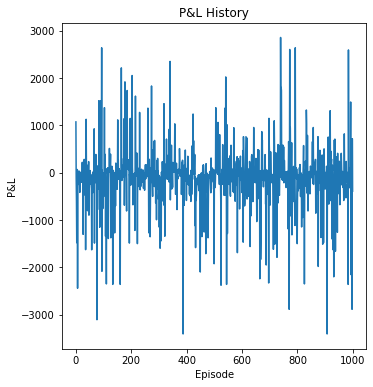

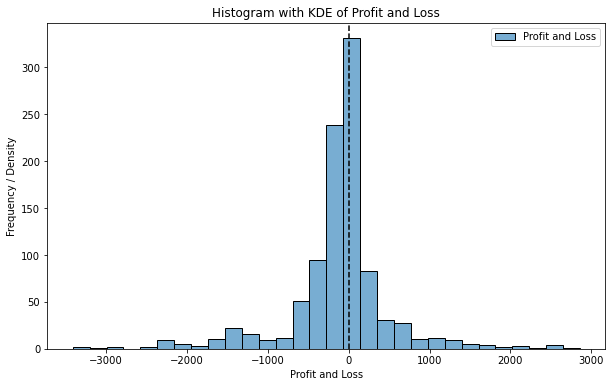

In [6]:
##Getting train datasets
features_train = Generate_Data.features_train
df_stock_train = Generate_Data.df_stock_train
call_options_train = Generate_Data.call_options_train


# Set up your environment with real AAPL stock and option data
env_train = Environment.Environment(
    stock_data=df_stock_train,
    option_data=call_options_train,
    features_data=features_train,
    T=30,
    n_steps=30,
    num_sold_opt=100,
    kappa=0.1,
    alpha=0.001
)
num_states = env_train.num_states
num_actions = env_train.num_actions

# Initialize the agent's brain
brain = BrainDelta(num_states, num_actions)

# Initialize the agent
delta_agent = AgentActionValueBase(brain)

# Train the agent
pl_history, reward_history, std_pl = train_agent(env_train, delta_agent, num_episodes=1000, num_steps=30)

plt.figure(figsize=(12, 6))

# Plot P&L history
plt.subplot(1, 2, 1)
plt.plot(pl_history)
plt.title("P&L History")
plt.xlabel("Episode")
plt.ylabel("P&L")

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(pl_history, kde=False, bins=30, label="Profit and Loss", alpha=0.6)

plt.axvline(0, color='k', linestyle='--')  # Mark zero for reference
plt.xlabel("Profit and Loss")
plt.ylabel("Frequency / Density")
plt.title("Histogram with KDE of Profit and Loss")
plt.legend()
plt.show()

plt.show()

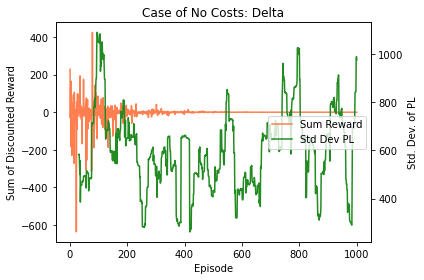

In [7]:
## DQN

episodes = np.array(list(range(1, len(reward_history) + 1)))

# Create a figure for dual-axis plotting
fig = plt.figure(figsize=[6, 4])
ax1 = fig.add_subplot(111)

# Plot Sum of Discounted Reward
ax1.plot(episodes, reward_history, color='coral', label='Sum Reward')
ax1.set_xlabel('Episode')
ax1.set_ylabel("Sum of Discounted Reward")
h1, l1 = ax1.get_legend_handles_labels()

# Create a secondary axis for Std Dev PL
ax2 = ax1.twinx()
ax2.plot(episodes, std_pl, color='forestgreen', label='Std Dev PL')
ax2.set_ylabel("Std. Dev. of PL")
h2, l2 = ax2.get_legend_handles_labels()

# Combine legends for both axes and set the title
ax2.legend(h1 + h2, l1 + l2, loc='center right')
ax1.set_title('Case of No Costs: Delta')

plt.tight_layout()
plt.show()

In [8]:
# Save the trained agent and brain
with open("models/trained_delta_agent.pkl", "wb") as f:
    pickle.dump(delta_agent, f)
